In [14]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import requests
import json
import re
from config import key

In [2]:
#user input Minnesota city name, string
city = "New Ulm"
#user input 3 digit fish_id, string
species = "WAE"
#user input search distance in miles from city, float
travel = 20
#user input number of results desired
requested_results = 5
#user input YYYY-MM-DD format, datetime64
start_date = np.datetime64("2000-01-31")
#user input gear from gear list, string, optional
gear = "Standard gill nets"

In [3]:
#read .csv files
fish_length_data = pd.read_csv(f"Resources/fish_length_info/fish_length_clean.csv",converters={"lake_ID": str})
fish_catch_data = pd.read_csv(f"Resources/fish_catch_info/fish_catch_clean.csv",converters={"lake_ID": str})
lakes_data = pd.read_csv("Resources/lake_info/lake_information_clean.csv", converters={"lake_ID": str})
fish_id = pd.read_csv("Resources/fish_id_info/fish_id_list.csv")

In [4]:
# call API to return city geo coordinates
params = {
    "city": city,
    "state": "MN",
    "country": "United States of America",
    "apiKey": key
}
base_url = "https://api.geoapify.com/v1/geocode/search"
response = requests.get(base_url, params=params).json()
lon = response["features"][0]["geometry"]["coordinates"][0]
lat = response["features"][0]["geometry"]["coordinates"][1]

In [37]:
#add methods

#convert coordinate lat or lon from degrees to radians; coordinate = -94.728528
def get_radians(coordinate):
    radian = coordinate*np.pi/180
    return radian

#calculate distance between 2 geographic degree points; lon1 = -94.728528 , lat1 = 44.308025
def get_distance(lat1, lon1, lat2, lon2):
    distance = np.arccos(np.sin(get_radians(lat1))*np.sin(get_radians(lat2)) + \
                         np.cos(get_radians(lat1))*np.cos(get_radians(lat2)) * \
                         np.cos(get_radians(lon2)-get_radians(lon1)))*3958.8
    return distance

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lakes
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species_name)
    plt.show()

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fishdict = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "fish_count"]        
        fish_list = []
        for _ in species_length.values:
            sample = _.replace("[","").replace("]","").split(",")
            sample = [int(x) for x in sample]
            fish_list = sample + fish_list
        fishdict[lakeid] = fish_list
    return fishdict

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    i = -1
    for lakeid in fishdict.keys():
        i += 1
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.title(f"{lake_names[i]} lengths for {species_name}")
            plt.show()

#input string data series with rows of "[1,1,2,2,2,3,4,7,7,7]"
#returns fish_count series column as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(dfseries):
    fish_length_averages = []
    for row in dfseries:
        #change string row to a list
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #convert list items to integer
        sample = [int(x) for x in sample if x != 0]
        fish_length_averages.append(np.mean(sample))
    return fish_length_averages

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "averageLength"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.scatter(sdate[_],fish[_], label=lake_names[_])
    plt.title(f"{ytext} measurements for {species_name}")
    plt.ylabel(f"{species_name} {ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lakes[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lakes[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(f"{ytext} trend for {lake_names[lake]}")
            ax1.scatter(sdate[lake],fish[lake], label=lake_names[lake])
            ax1.set_ylabel(f"{species_name} {ytext}")
            ax1.set_xlabel(f"R value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [ ]:
#add numeric survey date column as an integer to fish length
fish_length_df = fish_length_data
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)

In [6]:
#get list of lakes within travel distance 
closeby = lakes_data.loc[(get_distance(lat, lon, lakes_data["Latitude"], lakes_data["Longitude"]) < travel)]
closeby

,lake_ID,Lake Name,Lake County,Nearest Town,Lake Area,Littoral Area,Lake Depth,Mean Depth,Water Access Sites,Longitude,Latitude
595,07012500,Armstrong,Blue Earth,Butternut,0.00,0.00,0.0,0.0,[],-94.344356,44.152936
598,07009800,Crystal,Blue Earth,Lake Crystal,379.38,379.38,8.0,8.0,['was01426'],-94.203950,44.108543
608,07012400,Lieberg,Blue Earth,Butternut,0.00,0.00,0.0,0.0,[],-94.312602,44.153189
609,07010100,Lily,Blue Earth,Lake Crystal,0.00,0.00,0.0,0.0,[],-94.222843,44.114100
624,08002900,Bachelor,Brown,Stark (Brown),0.00,0.00,0.0,0.0,[],-94.652755,44.255924
626,08001100,Clear,Brown,New Ulm,251.78,251.78,8.0,5.0,['was01420'],-94.520594,44.259424
627,08001300,Domeier,Brown,Stark (Brown),0.00,0.00,0.0,0.0,[],-94.548342,44.246877
628,08002600,Hanska,Brown,Hanska,1794.97,1773.00,16.0,4.5,"['was01418', 'was02762', 'was01425']",-94.619124,44.137006
631,08001000,Omsrud,Brown,Hanska,0.00,0.00,0.0,0.0,[],-94.546603,44.141747
632,08001900,Rolloff Slough,Brown,Essig,0.00,0.00,0.0,0.0,[],-94.557510,44.328364


In [7]:
lakes = list(closeby["lake_ID"])
lakes

['07012500',
 '07009800',
 '07012400',
 '07010100',
 '08002900',
 '08001100',
 '08001300',
 '08002600',
 '08001000',
 '08001900',
 '08001400',
 '08004500',
 '08002700',
 '72008900',
 '52003000',
 '52002300',
 '52003700',
 '52003300',
 '52001500',
 '52003400',
 '65002800',
 '72006600',
 '72009500',
 '72003600',
 '72006900',
 '72009300',
 '83002100',
 '83001900']

In [8]:
#JSON response for MN lake id number.
def get_catch_info(lake_id):
    response = requests.get("https://maps2.dnr.state.mn.us/cgi-bin/lakefinder/detail.cgi?type=lake_survey&id="+lake_id)
    return response.json()

def get_fish_catch_summary_data(catch_info):
    fish_catch_list = []
    for i in range(len(catch_info["result"]["surveys"])): 
        survey_date = catch_info["result"]["surveys"][i]["surveyDate"]
        survey_id = catch_info["result"]["surveys"][i]["surveyID"]
        for j in range(len(catch_info["result"]["surveys"][i]["fishCatchSummaries"])):
            fish_catch_summary = catch_info["result"]["surveys"][i]["fishCatchSummaries"][j]
            fish_catch_summary["lake_ID"] = catch_info["result"]["DOWNumber"]
            fish_catch_summary["survey_date"] = survey_date
            fish_catch_summary["survey_ID"] = survey_id
            fish_catch_list.append(fish_catch_summary)
    return fish_catch_list

In [9]:
#retrieve catch survey data from API for all lakes within radius that have survey
fish_catch_data = [get_catch_info(x) for x in lakes if get_catch_info(x)["status"] == "SUCCESS"]

[{'timestamp': 1686862906,
  'result': {'areaAcres': 379.38,
   'accesses': [{'location': '',
     'lakeAccessComments': 'Good access with a dock and fishing pier.',
     'accessTypeId': 'CO',
     'publicUseAuthCode': 'OPEN',
     'ownerTypeId': 'CIT'}],
   'sampledPlants': [],
   'averageWaterClarity': '1.9',
   'waterClarity': [['08/15/2022', '1.5'],
    ['08/12/2016', '3'],
    ['08/07/2006', '1.2']],
   'littoralAcres': 379.38,
   'maxDepthFeet': 8,
   'lakeName': 'Crystal',
   'meanDepthFeet': 8,
   'DOWNumber': '07009800',
   'officeCode': 'F417',
   'shoreLengthMiles': 5.45,
   'surveys': [{'surveySubType': 'Re-Survey',
     'narrative': '<p>AN EXCELLENT WALLEYE POPULATION IS PRESENT AVERAG- ING 25.20/GILLNET COMPARED TO 65.50/GILLNET IN 82. THE PRESENT WALLEYE POPULATION IS WELL REPRESENTED BY THE SAME YEAR CLASSES THAT WERE SAMPLED IN 82. LARGER WALLEYES MAKE UP THE PRESENT POPULATION WITH MANY FISH MEASURING 14.0 - 22.0 INCHES. THE 87 NETTING WAS DOMINATED BY I,V,VI, AND VII

In [10]:
#alter API data return so it can be used in pandas dataframe
catch_list = []
fish_catch_data_clean = get_fish_catch_summary_data(fish_catch_data[0])
for _ in range(len(fish_catch_data)):
    catch = get_fish_catch_summary_data(fish_catch_data[_])
    for _ in range(len(catch)):
        sample = catch[_]
        catch_list.append(sample)

In [27]:
fish_catch_df = pd.DataFrame(catch_list)
fish_catch_df

,totalWeight,quartileCount,quartileWeight,species,averageWeight,totalCatch,CPUE,gearCount,gear,lake_ID,survey_date,survey_ID
0,10.31,1.4-13.8,0.2-0.4,BLC,0.18,58,11.60,5.0,Standard gill nets,07009800,1987-08-10,118504
1,347.15,30.3-150.6,0.2-0.4,BLB,0.24,1456,291.20,5.0,Standard gill nets,07009800,1987-08-10,118504
2,81.90,0.8-6.5,0.9-2.0,WTS,0.95,86,17.20,5.0,Standard gill nets,07009800,1987-08-10,118504
3,13.50,1.2-20.0,0.1-0.4,BLG,0.16,83,13.83,6.0,Standard trap nets,07009800,1987-08-10,118504
4,2.80,0.3-3.8,0.1-0.3,YEP,0.20,14,2.33,6.0,Standard trap nets,07009800,1987-08-10,118504
...,...,...,...,...,...,...,...,...,...,...,...,...
859,0.00,N/A,N/A,BLB,0.00,6,3.00,2.0,Survey seining,83002100,2002-05-28,119621
860,25512.00,11.5-132.6,0.2-0.4,BLB,0.12,462,51.33,9.0,Standard trap nets,83002100,2002-05-28,119621
861,100.00,0.3-3.8,0.1-0.3,YEP,0.22,1,0.11,9.0,Standard trap nets,83002100,2010-06-01,3701014757874013
862,11113.00,30.3-150.6,0.2-0.4,BLB,0.26,96,96.00,1.0,Standard gill nets,83002100,2010-06-01,3701014757874013


In [28]:
#sort and format year survey data then convert to datetime
def survey_date_cleaner(dfseries):
    dfseries = dfseries.copy()
    for _ in range(len(dfseries)):
        dfseries[_] = dfseries[_].replace("/","-")
        if matches := re.search(r"^(\d?\d{1})-(\d?\d{1})-(\d{4})$", dfseries[_], re.IGNORECASE):
            dfseries[_] = f"{matches.group(3)}-{matches.group(2)}-{matches.group(1)}"
        try:
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
        except ValueError:
            if matches := re.search(r"^(\d{4})-(\d?\d{1})-(\d?\d{1})$", dfseries[_], re.IGNORECASE):
                dfseries[_] = f"{matches.group(1)}-{matches.group(3)}-{matches.group(2)}"
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
    dfseries = pd.to_datetime(dfseries,format="%Y-%m-%d")
    return dfseries

#input CPUE column data series
#drop strings from cpue data series and convert to int(found some "? marks")
def cpue_cleaner(dfseries):
    i=0
    for _ in dfseries:
        try:
            np.float64(_)
            i = i + 1
        except ValueError:
            print(i, _,"valueerror")
            dfseries = dfseries.drop([i])
            i = i + 1
    dfseries = pd.to_numeric(dfseries)
    return dfseries

#input quartile data series
#split lower quartile and convert to float
def lower_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[0]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

#input quartile data series
#split upper quartile and convert to float
def upper_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[1]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

In [29]:
#clean incomming API data
fish_catch_df["CPUE"] = cpue_cleaner(fish_catch_df["CPUE"])
fish_catch_df["survey_date"] = survey_date_cleaner(fish_catch_df["survey_date"])
fish_catch_df["count_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["count_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["weight_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["weight_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["gearCount"] = fish_catch_df["gearCount"].astype("int")
fish_catch_df = fish_catch_df.drop(columns=["quartileCount", "quartileWeight"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 851 to 56
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   totalWeight            864 non-null    float64       
 1   species                864 non-null    object        
 2   averageWeight          864 non-null    object        
 3   totalCatch             864 non-null    int64         
 4   CPUE                   864 non-null    float64       
 5   gearCount              864 non-null    int32         
 6   gear                   864 non-null    object        
 7   lake_ID                864 non-null    object        
 8   survey_date            864 non-null    datetime64[ns]
 9   survey_ID              864 non-null    object        
 10  count_lower_quartile   620 non-null    float64       
 11  count_upper_quartile   620 non-null    float64       
 12  weight_lower_quartile  605 non-null    float64       
 13  weig

In [30]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)

In [32]:
cpue_data = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                              (fish_catch_df["survey_date"] >= start_date) & \
                              (fish_catch_df["gear"] == gear)]
cpue_data = cpue_data.groupby(["lake_ID", "species"]).median() ["CPUE"]
species_name = fish_id.loc[fish_id["fish_id"] == species, "fish_description"].values[0]
species_name

'Walleye'

In [ ]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, lakes, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, lakes, species, start_date)

In [33]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, lakes, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, lakes, species, start_date)

In [34]:
#filter and prepare a CPUE list for box plots
cpuelist = get_cpue_box(fish_catch_df, lakes, species, start_date)

In [ ]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, lakes, species, start_date)

In [35]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, lakes, species, start_date)

In [ ]:
#create fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, lakes, species, start_date)

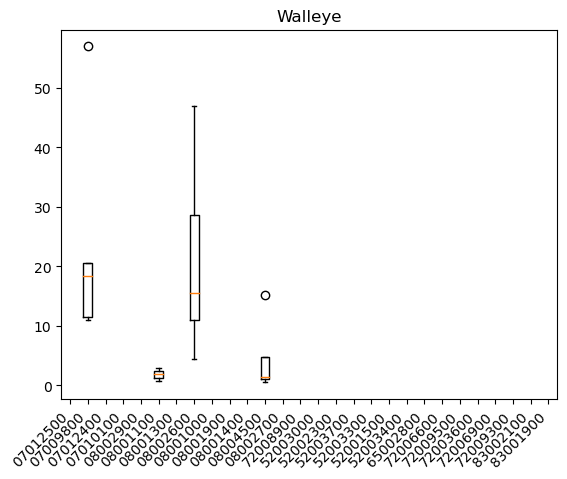

In [38]:
#plot boxplot of CPUE per lake
plot_cpue_box(cpuelist, lakes)

In [ ]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, lakes, ytext="CPUE")

In [ ]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, lakes, "CPUE")

In [ ]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

In [ ]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, lakes, "Avg Length")

In [ ]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, lakes, "Avg Length")

#### End of Report